# Training feature selection

## Description

...


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import json
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

import numpy as np
import pandas as pd
from joblib import dump

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import warnings  # Import the warnings module

import matplotlib.colors as mcolors

from statsmodels.stats.outliers_influence import variance_inflation_factor

## Load training data and label dictionary

We will load the training data saved from the [feature extracion notebook](3_Training_feature_extraction.ipynb), along with the mapping between crop labels and the numerical classes.

In [2]:
# dataset_name1 = 'sb16_17';
dataset_name2 = 'sb17_18';
dataset_name3 = 'sb18_19';
dataset_name4 = 'sb19_20';
dataset_name5 = 'sb20_21';

dataset_suffix = '_tree_cleaned';

predictor_column = 6; # Column where we start selecting the predictors
ndvi_threshold = 0; # NDVI min Threshold

In [3]:
base_path = 'Input'
output_file1 = os.path.join(base_path, f'{dataset_name1}{dataset_suffix}.csv')
output_file2 = os.path.join(base_path, f'{dataset_name2}{dataset_suffix}.csv')
output_file3 = os.path.join(base_path, f'{dataset_name3}{dataset_suffix}.csv')
output_file4 = os.path.join(base_path, f'{dataset_name4}{dataset_suffix}.csv')
output_file5 = os.path.join(base_path, f'{dataset_name5}{dataset_suffix}.csv')
# Load the newly generated CSV file
df1 = pd.read_csv(output_file1)
df2 = pd.read_csv(output_file2)
df3 = pd.read_csv(output_file3)
df4 = pd.read_csv(output_file4)
df5 = pd.read_csv(output_file5)
# add df1 to df
df = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
# print the number of rows
print(f"Number of rows: {len(df)}")
df = df.dropna()
print(df.shape)

Number of rows: 12734413


KeyboardInterrupt: 

In [ ]:
# Visualize the features in the dataset
features = df.columns
# Print the number of predictors
print(f'The number of features is: {len(features)}')
# List the potential predictors
print(features)

The number of features is: 57
Index(['FIELDID', 'Crop_type', 'Irrigation', 'catname', 'no_of_crop',
       'area_ha', 'Year', 'week', 'chirps_mean_prec', 'chirps_sum_prec',
       'chirps_max_prec', 'chirps_min_prec', 'chirps_std_prec',
       'chirps_cnt_prec', 'RSM_mean', 'RSM_min', 'RSM_max', 'era5_temp2m',
       'era5_temp2mmin', 'era5_temp2max', 'era5_totprec', 'era5_rh',
       'era5_swi', 'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi',
       'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi',
       'veg_median_evi', 'veg_median_lai', 'veg_median_pvr', 'veg_median_msi',
       'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai', 'veg_max_pvr',
       'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai',
       'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi',
       'veg_std_lai', 'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 'sar_vh',
       'sar_vv', 'sar_angle', 'sar_sigma_vh_linear', 'sar_sigma_vv_linear',
       'sar_p_ratio', 'sar_rvi', 

In [ ]:
# print unique values in 'Irrigation' and their counts
print(df['Irrigation'].value_counts())

Irrigation
Rainfed      2000140
Irrigated     768374
Name: count, dtype: int64


In [ ]:
# add a new column 'Irrigation_code' to the dataframe, 1 for Irrigated and 0 for Rainfed
df['Irrigation_code'] = df['Irrigation'].apply(lambda x: 1 if x == 'Irrigated' else 0) 
# print the number of rows with Irrigation_code = 1
print(f"Number of rows with Irrigation_code = 1: {len(df[df['Irrigation_code'] == 1])}")
# print the number of rows with Irrigation_code = 0
print(f"Number of rows with Irrigation_code = 0: {len(df[df['Irrigation_code'] == 0])}")

Number of rows with Irrigation_code = 1: 768374
Number of rows with Irrigation_code = 0: 2000140


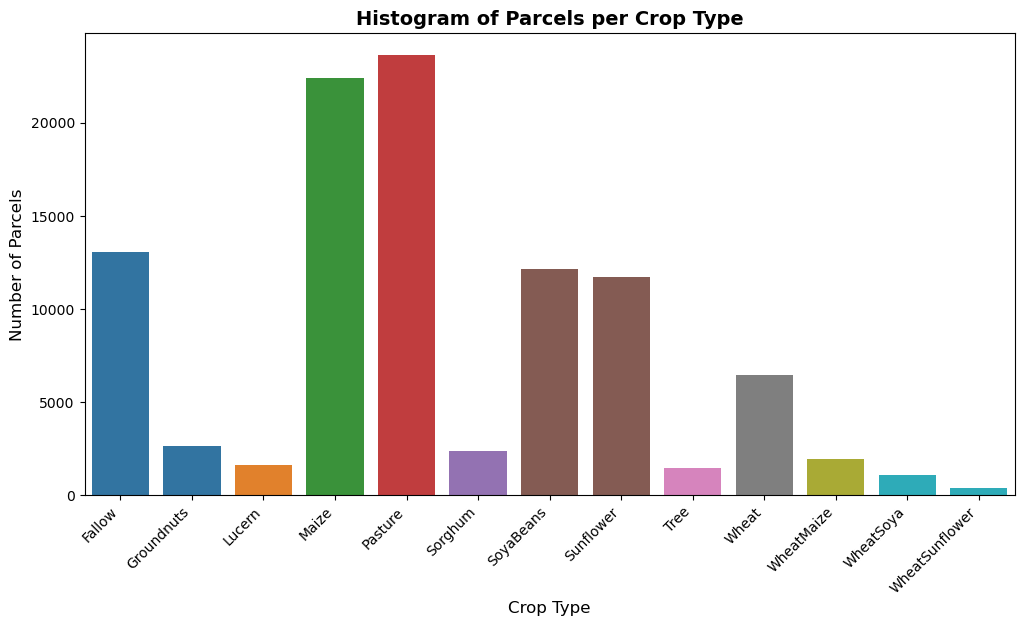

In [ ]:
# Ensure Crop_type column exists
if "Crop_type" not in df.columns:
    raise ValueError("The dataframe df is missing the 'Crop_type' column.")

# Count unique FIELDID values per Crop_type
crop_counts = df.groupby('Crop_type')['FIELDID'].nunique().reset_index()
crop_counts.columns = ['Crop_type', 'Parcel_Count']

# Define distinct colors for each crop type
colors = plt.cm.get_cmap('tab10', len(crop_counts))  # Use 'tab10' colormap
crop_color_map = {crop: colors(i) for i, crop in enumerate(crop_counts['Crop_type'])}

# Plot the histogram
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    x='Crop_type', y='Parcel_Count', data=crop_counts,
    palette=[crop_color_map[crop] for crop in crop_counts['Crop_type']]
)

# Improve readability
ax.set_title("Histogram of Parcels per Crop Type", fontsize=14, fontweight='bold')
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.set_xticklabels(crop_counts['Crop_type'], rotation=45, ha='right')  # Rotate x-axis labels

plt.show()



In [ ]:
# print number of parcels for each crop type
print(crop_counts)


         Crop_type  Parcel_Count
0           Fallow         13048
1       Groundnuts          2634
2           Lucern          1619
3            Maize         22397
4          Pasture         23630
5          Sorghum          2384
6        SoyaBeans         12140
7        Sunflower         11709
8             Tree          1435
9            Wheat          6429
10      WheatMaize          1917
11       WheatSoya          1085
12  WheatSunflower           392


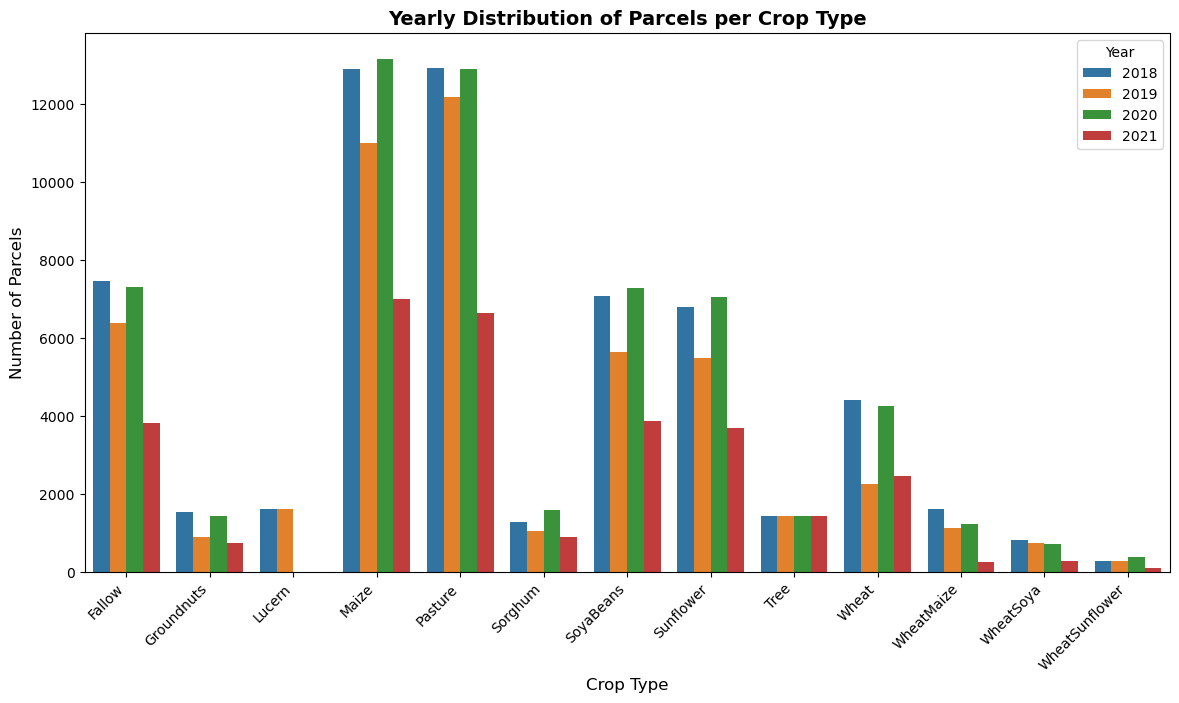

In [ ]:
# Ensure required columns exist
if "Crop_type" not in df.columns or "Year" not in df.columns:
    raise ValueError("The dataframe df is missing required columns ('Crop_type' or 'Year').")

# Count unique parcels per Crop_type and Year
crop_year_counts = df.groupby(['Crop_type', 'Year'])['FIELDID'].nunique().reset_index()
crop_year_counts.columns = ['Crop_type', 'Year', 'Parcel_Count']

# Set figure size
fig, ax = plt.subplots(figsize=(14, 7))

# Use a color palette with enough distinct colors
palette = sns.color_palette("tab10", len(crop_year_counts['Year'].unique()))

# Create the bar plot
sns.barplot(
    x='Crop_type', y='Parcel_Count', hue='Year', data=crop_year_counts,
    palette=palette, dodge=True, ax=ax
)

# Improve readability
ax.set_title("Yearly Distribution of Parcels per Crop Type", fontsize=14, fontweight='bold')
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.set_xticklabels(crop_year_counts['Crop_type'].unique(), rotation=45, ha='right')  # Rotate x-axis labels
ax.legend(title="Year")

plt.show()


In [ ]:
# print number of parcels for each crop type and year
print(crop_year_counts)

         Crop_type  Year  Parcel_Count
0           Fallow  2018          7474
1           Fallow  2019          6396
2           Fallow  2020          7302
3           Fallow  2021          3820
4       Groundnuts  2018          1538
5       Groundnuts  2019           895
6       Groundnuts  2020          1441
7       Groundnuts  2021           736
8           Lucern  2018          1619
9           Lucern  2019          1619
10           Maize  2018         12903
11           Maize  2019         11015
12           Maize  2020         13172
13           Maize  2021          6998
14         Pasture  2018         12942
15         Pasture  2019         12187
16         Pasture  2020         12910
17         Pasture  2021          6650
18         Sorghum  2018          1289
19         Sorghum  2019          1048
20         Sorghum  2020          1594
21         Sorghum  2021           891
22       SoyaBeans  2018          7070
23       SoyaBeans  2019          5645
24       SoyaBeans  2020 

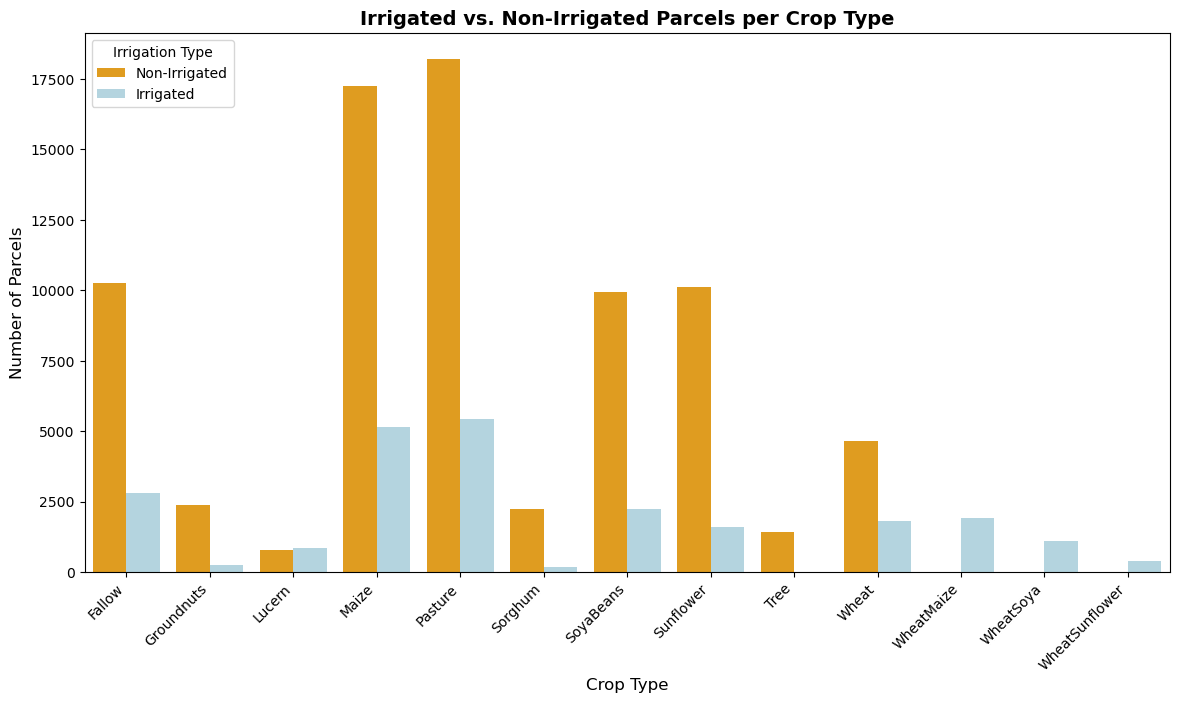

In [ ]:
# Ensure required columns exist
if "Crop_type" not in df.columns or "Irrigation_code" not in df.columns:
    raise ValueError("The dataframe gdf_crop is missing required columns ('Crop_type' or 'Irrigation_code').")

# Count unique parcels per Crop_type and Irrigation_code type
irrigation_counts = df.groupby(['Crop_type', 'Irrigation_code'])['FIELDID'].nunique().reset_index()
irrigation_counts.columns = ['Crop_type', 'Irrigation_code', 'Parcel_Count']

# Map irrigation values to readable labels
irrigation_counts['Irrigation_code'] = irrigation_counts['Irrigation_code'].map({0: 'Non-Irrigated', 1: 'Irrigated'})

# Set figure size
fig, ax = plt.subplots(figsize=(14, 7))

# Switch colors: Orange for Non-Irrigated, Light Blue for Irrigated
palette = {"Non-Irrigated": "orange", "Irrigated": "lightblue"}

# Create the bar plot
sns.barplot(
    x='Crop_type', y='Parcel_Count', hue='Irrigation_code', data=irrigation_counts,
    palette=palette, dodge=True, ax=ax
)

# Improve readability
ax.set_title("Irrigated vs. Non-Irrigated Parcels per Crop Type", fontsize=14, fontweight='bold')
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.set_xticklabels(irrigation_counts['Crop_type'].unique(), rotation=45, ha='right')  # Rotate x-axis labels
ax.legend(title="Irrigation Type")

plt.show()


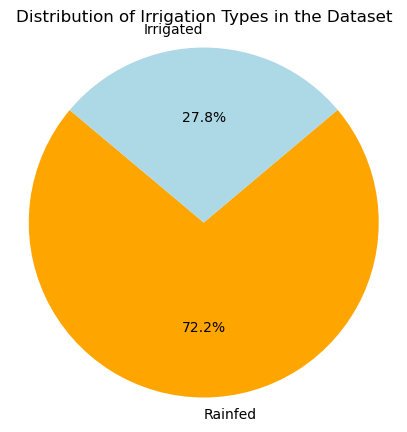

In [ ]:
# plot pie chart of unique parcels belonging to each irrigation type
def plot_pie_chart(df, title):
    # Count unique parcels for each irrigation type
    counts = df['Irrigation'].value_counts()

    # Define custom colors: blue for Irrigated, orange for Rainfed
    color_map = {'Irrigated': 'lightblue', 'Rainfed': 'orange'}
    # Match the color order to the index order
    colors = [color_map.get(label, 'gray') for label in counts.index]

    # Create a pie chart
    plt.figure(figsize=(5, 5))
    plt.pie(counts, labels=counts.index, colors=colors,
            autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

# Example usage
plot_pie_chart(df, "Distribution of Irrigation Types in the Dataset")

In [ ]:
# Print the number of parcels for each crop type and irrigation type
print(irrigation_counts)

         Crop_type Irrigation_code  Parcel_Count
0           Fallow   Non-Irrigated         10265
1           Fallow       Irrigated          2786
2       Groundnuts   Non-Irrigated          2371
3       Groundnuts       Irrigated           263
4           Lucern   Non-Irrigated           780
5           Lucern       Irrigated           839
6            Maize   Non-Irrigated         17256
7            Maize       Irrigated          5146
8          Pasture   Non-Irrigated         18220
9          Pasture       Irrigated          5413
10         Sorghum   Non-Irrigated          2225
11         Sorghum       Irrigated           159
12       SoyaBeans   Non-Irrigated          9921
13       SoyaBeans       Irrigated          2219
14       Sunflower   Non-Irrigated         10119
15       Sunflower       Irrigated          1593
16            Tree   Non-Irrigated          1435
17           Wheat   Non-Irrigated          4636
18           Wheat       Irrigated          1794
19      WheatMaize  

In [ ]:
# # remove Wheat parcels in Non-Irrigated parcels in df
# df_corr = df[~((df['Crop_type'] == 'Wheat') & (df['Irrigation'] == 0))]

# # remove Lucern parcels in Non-Irrigated parcels in df
# df_corr = df_corr[~((df_corr['Crop_type'] == 'Lucern') & (df_corr['Irrigation'] == 0))]

# # Print the number of parcels for each crop type and irrigation type
# print(df_corr.groupby(['Crop_type', 'Irrigation'])['FIELDID'].nunique())
df_corr = df.copy()

## NDVI Threshold Filtering: >= ndvi_threshold

We filter out rows where the median NDVI (`veg_median_ndvi`) is below 0.2 to focus on time periods with significant vegetation. After filtering, we also calculate and print the number of removed rows.


The number of included rows is: 2768285
The number of removed rows is: 229


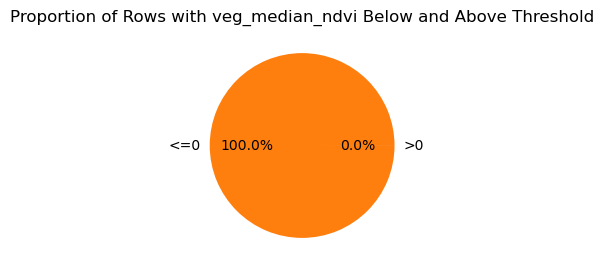

In [ ]:
# pie chart of of rows with veg_median_ndvi < threshold and veg_median_ndvi >= threshold
# Calculate the number of rows with veg_median_ndvi < threshold and veg_median_ndvi >= threshold

# Remove rows with veg_median_ndvi < threshold
df1 = df_corr[df_corr['veg_median_ndvi'] >= ndvi_threshold]
# Print the number of included rows
print(f'The number of included rows is: {df1.shape[0]}')
# Print the number of removed rows
print(f'The number of removed rows is: {df_corr.shape[0] - df1.shape[0]}')
below_threshold = df_corr[df_corr['veg_median_ndvi'] < ndvi_threshold].shape[0]
above_threshold = df_corr[df_corr['veg_median_ndvi'] >= ndvi_threshold].shape[0]
# Create a pie chart
plt.figure(figsize=(3, 3))
plt.pie([below_threshold, above_threshold], labels=['>' + str(ndvi_threshold), '<=' + str(ndvi_threshold)], autopct='%1.1f%%')
plt.title('Proportion of Rows with veg_median_ndvi Below and Above Threshold')
plt.show()


In [ ]:
# Print the number of rows
print(f"Number of rows: {len(df1)}")

Number of rows: 2768285


In [ ]:
df1 = df

### Inspect the label and feature columns

As shown below, we have over 40 features extracted.

In [ ]:
# Calculate the number of predictors: columns after first 9 columns
predictors = df1.columns[predictor_column:]
# Print the number of predictors
print(f'The number of predictors is: {len(predictors)}')
# List the potential predictors
print(predictors)
print(df1.shape)

The number of predictors is: 52
Index(['Year', 'week', 'chirps_mean_prec', 'chirps_sum_prec',
       'chirps_max_prec', 'chirps_min_prec', 'chirps_std_prec',
       'chirps_cnt_prec', 'RSM_mean', 'RSM_min', 'RSM_max', 'era5_temp2m',
       'era5_temp2mmin', 'era5_temp2max', 'era5_totprec', 'era5_rh',
       'era5_swi', 'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi',
       'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi',
       'veg_median_evi', 'veg_median_lai', 'veg_median_pvr', 'veg_median_msi',
       'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai', 'veg_max_pvr',
       'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai',
       'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi',
       'veg_std_lai', 'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 'sar_vh',
       'sar_vv', 'sar_angle', 'sar_sigma_vh_linear', 'sar_sigma_vv_linear',
       'sar_p_ratio', 'sar_rvi', 'sar_rcspr', 'Irrigation_code'],
      dtype='object')
(2768514, 58)


In [ ]:
# drop NaN values
df2 = df1.dropna()
print(df1.shape)

(2768514, 58)


In [ ]:
# Investigate value counts for each class in Crop_type
print(df2['Crop_type'].value_counts())

Crop_type
Pasture           605569
Maize             597702
Fallow            347833
Sunflower         325865
SoyaBeans         313263
Wheat             181804
Tree              113878
WheatMaize         67442
Groundnuts         66647
Sorghum            61949
Lucern             37391
WheatSoya          33721
WheatSunflower     15450
Name: count, dtype: int64


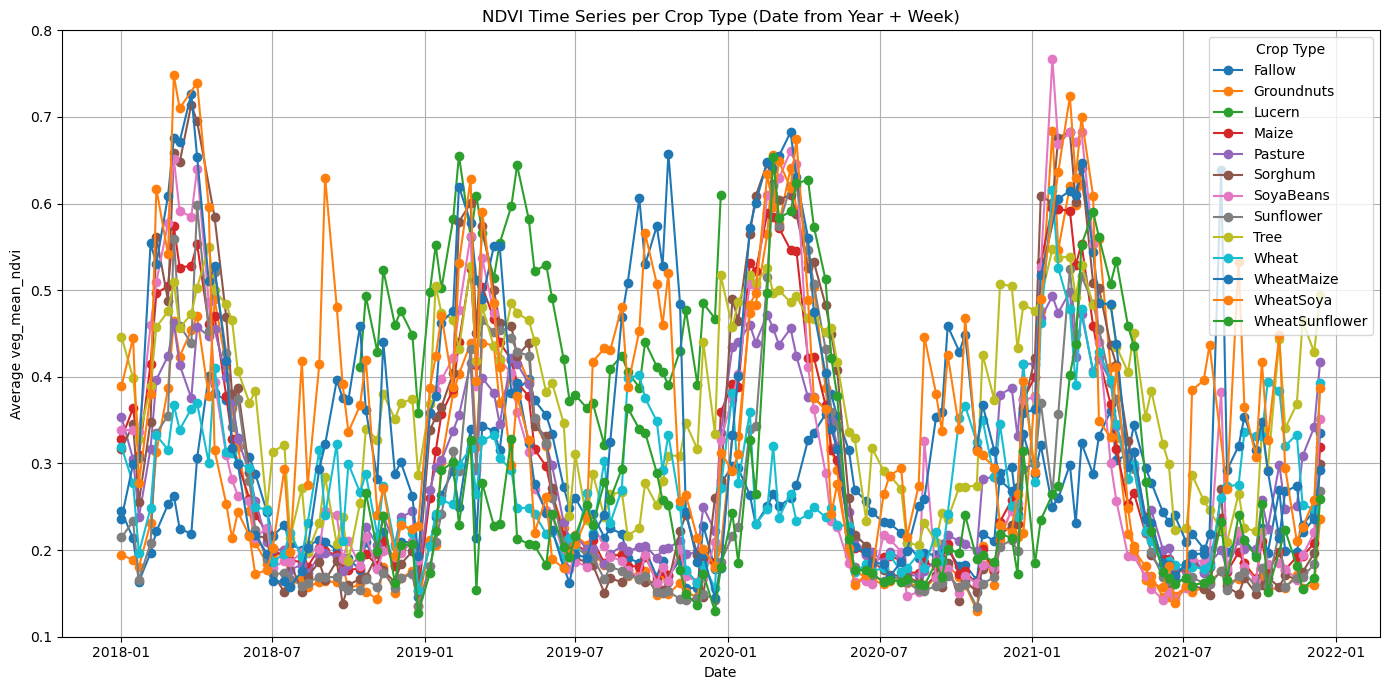

In [ ]:
# Ensure numeric
df2["week"] = pd.to_numeric(df2["week"], errors="coerce")
df2["veg_mean_ndvi"] = pd.to_numeric(df2["veg_mean_ndvi"], errors="coerce")
df2["Year"] = pd.to_numeric(df2["Year"], errors="coerce")

# Drop rows with invalid weeks or years
df2 = df2.dropna(subset=["Year", "week"])
df2 = df2[df2["week"] > 0]  # ISO weeks start from 1

# Create datetime from Year, Week, and weekday=1 (Monday)
from datetime import datetime

def iso_to_date(year, week):
    try:
        return datetime.fromisocalendar(int(year), int(week), 1)
    except:
        return pd.NaT

df2["date"] = df2.apply(lambda row: iso_to_date(row["Year"], row["week"]), axis=1)
df2 = df2.dropna(subset=["date"])

# Group by crop type and date
avg_ndvi = df2.groupby(["Crop_type", "date"], as_index=False)["veg_mean_ndvi"].mean()

# Plotting
plt.figure(figsize=(14, 7))

for crop in avg_ndvi["Crop_type"].unique():
    subset = avg_ndvi[avg_ndvi["Crop_type"] == crop].sort_values("date")
    plt.plot(
        subset["date"].to_numpy(),
        subset["veg_mean_ndvi"].to_numpy(),
        marker="o",
        linestyle="-",
        label=crop
    )

plt.xlabel("Date")
plt.ylabel("Average veg_mean_ndvi")
plt.title("NDVI Time Series per Crop Type (Date from Year + Week)")
plt.legend(title="Crop Type")
plt.grid(True)
plt.tight_layout()
plt.ylim(0.1, 0.8)
plt.show()


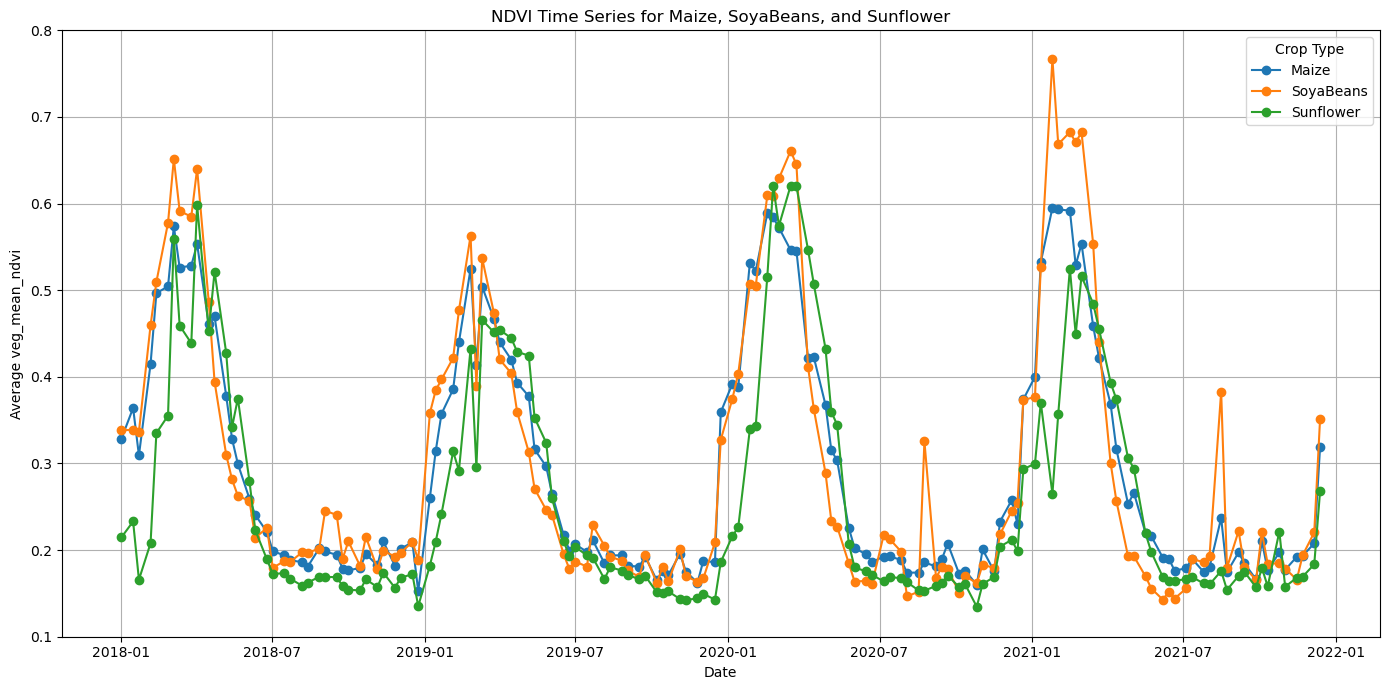

In [ ]:
# Ensure numeric
df2["week"] = pd.to_numeric(df2["week"], errors="coerce")
df2["veg_mean_ndvi"] = pd.to_numeric(df2["veg_mean_ndvi"], errors="coerce")
df2["Year"] = pd.to_numeric(df2["Year"], errors="coerce")

# Drop rows with invalid weeks or years
df2 = df2.dropna(subset=["Year", "week"])
df2 = df2[df2["week"] > 0]  # ISO weeks start from 1

# Filter only for Maize, SoyaBeans, and Sunflower
df_crop = df2[df2["Crop_type"].isin(["Maize", "SoyaBeans", "Sunflower"])].copy()

# Create datetime from Year, Week, and weekday=1 (Monday)
def iso_to_date(year, week):
    try:
        return datetime.fromisocalendar(int(year), int(week), 1)
    except:
        return pd.NaT

df_crop["date"] = df_crop.apply(lambda row: iso_to_date(row["Year"], row["week"]), axis=1)

df_crop = df_crop.dropna(subset=["date"])

# Group by crop type and date
avg_ndvi = df_crop.groupby(["Crop_type", "date"], as_index=False)["veg_mean_ndvi"].mean()

# Plotting
plt.figure(figsize=(14, 7))

for crop in ["Maize", "SoyaBeans", "Sunflower"]:
    subset = avg_ndvi[avg_ndvi["Crop_type"] == crop].sort_values("date")
    plt.plot(
        subset["date"].to_numpy(),
        subset["veg_mean_ndvi"].to_numpy(),
        marker="o",
        linestyle="-",
        label=crop
    )

plt.xlabel("Date")
plt.ylabel("Average veg_mean_ndvi")
plt.title("NDVI Time Series for Maize, SoyaBeans, and Sunflower")
plt.legend(title="Crop Type")
plt.grid(True)
plt.tight_layout()
plt.ylim(0.1, 0.8)
plt.show()


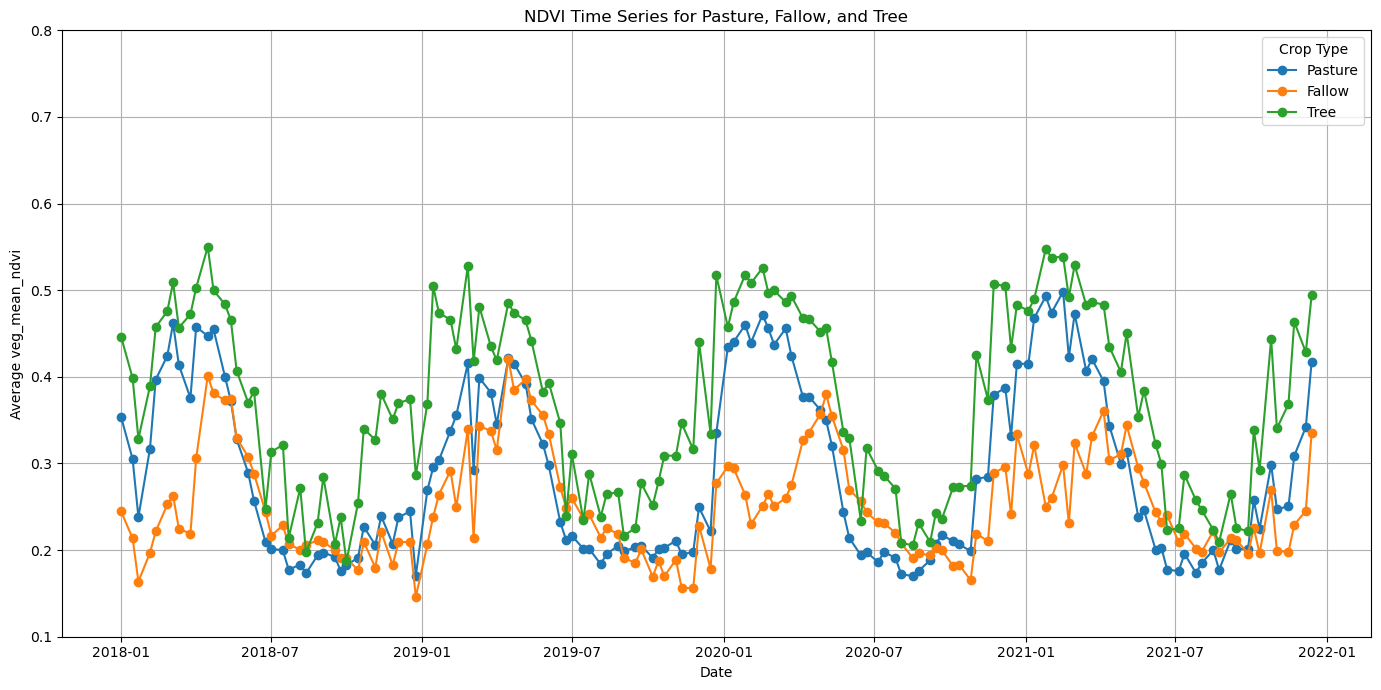

In [ ]:
# Ensure numeric
df2["week"] = pd.to_numeric(df2["week"], errors="coerce")
df2["veg_mean_ndvi"] = pd.to_numeric(df2["veg_mean_ndvi"], errors="coerce")
df2["Year"] = pd.to_numeric(df2["Year"], errors="coerce")

# Drop rows with invalid weeks or years
df2 = df2.dropna(subset=["Year", "week"])
df2 = df2[df2["week"] > 0]  # ISO weeks start from 1

# Filter only for Pasture, Fallow, and Tree
df_crop = df2[df2["Crop_type"].isin(["Pasture", "Fallow", "Tree"])].copy()

# Create datetime from Year, Week, and weekday=1 (Monday)
def iso_to_date(year, week):
    try:
        return datetime.fromisocalendar(int(year), int(week), 1)
    except:
        return pd.NaT

df_crop["date"] = df_crop.apply(lambda row: iso_to_date(row["Year"], row["week"]), axis=1)
df_crop = df_crop.dropna(subset=["date"])

# Group by crop type and date
avg_ndvi = df_crop.groupby(["Crop_type", "date"], as_index=False)["veg_mean_ndvi"].mean()

# Plotting
plt.figure(figsize=(14, 7))

for crop in ["Pasture", "Fallow", "Tree"]:
    subset = avg_ndvi[avg_ndvi["Crop_type"] == crop].sort_values("date")
    plt.plot(
        subset["date"].to_numpy(),
        subset["veg_mean_ndvi"].to_numpy(),
        marker="o",
        linestyle="-",
        label=crop
    )

plt.xlabel("Date")
plt.ylabel("Average veg_mean_ndvi")
plt.title("NDVI Time Series for Pasture, Fallow, and Tree")
plt.legend(title="Crop Type")
plt.grid(True)
plt.tight_layout()
plt.ylim(0.1, 0.8)
plt.show()


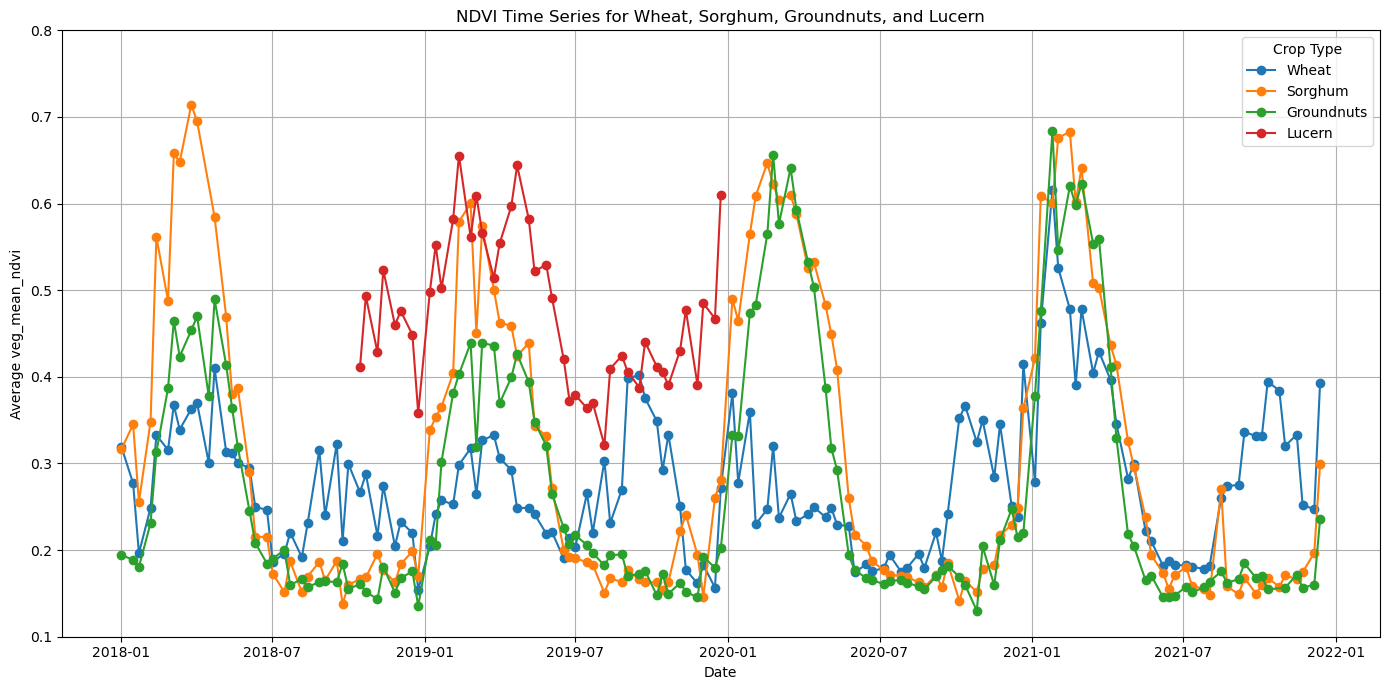

In [ ]:
# Ensure numeric
df2["week"] = pd.to_numeric(df2["week"], errors="coerce")
df2["veg_mean_ndvi"] = pd.to_numeric(df2["veg_mean_ndvi"], errors="coerce")
df2["Year"] = pd.to_numeric(df2["Year"], errors="coerce")

# Drop rows with invalid weeks or years
df2 = df2.dropna(subset=["Year", "week"])
df2 = df2[df2["week"] > 0]  # ISO weeks start from 1

# Filter only for Wheat, Sorghum, Groundnuts, Lucern
selected_crops = ["Wheat", "Sorghum", "Groundnuts", "Lucern"]
df_crop = df2[df2["Crop_type"].isin(selected_crops)].copy()

# Create datetime from Year, Week, and weekday=1 (Monday)
def iso_to_date(year, week):
    try:
        return datetime.fromisocalendar(int(year), int(week), 1)
    except:
        return pd.NaT

df_crop["date"] = df_crop.apply(lambda row: iso_to_date(row["Year"], row["week"]), axis=1)
df_crop = df_crop.dropna(subset=["date"])

# Group by crop type and date
avg_ndvi = df_crop.groupby(["Crop_type", "date"], as_index=False)["veg_mean_ndvi"].mean()

# Plotting
plt.figure(figsize=(14, 7))

for crop in selected_crops:
    subset = avg_ndvi[avg_ndvi["Crop_type"] == crop].sort_values("date")
    plt.plot(
        subset["date"].to_numpy(),
        subset["veg_mean_ndvi"].to_numpy(),
        marker="o",
        linestyle="-",
        label=crop
    )

plt.xlabel("Date")
plt.ylabel("Average veg_mean_ndvi")
plt.title("NDVI Time Series for Wheat, Sorghum, Groundnuts, and Lucern")
plt.legend(title="Crop Type")
plt.grid(True)
plt.tight_layout()
plt.ylim(0.1, 0.8)
plt.show()


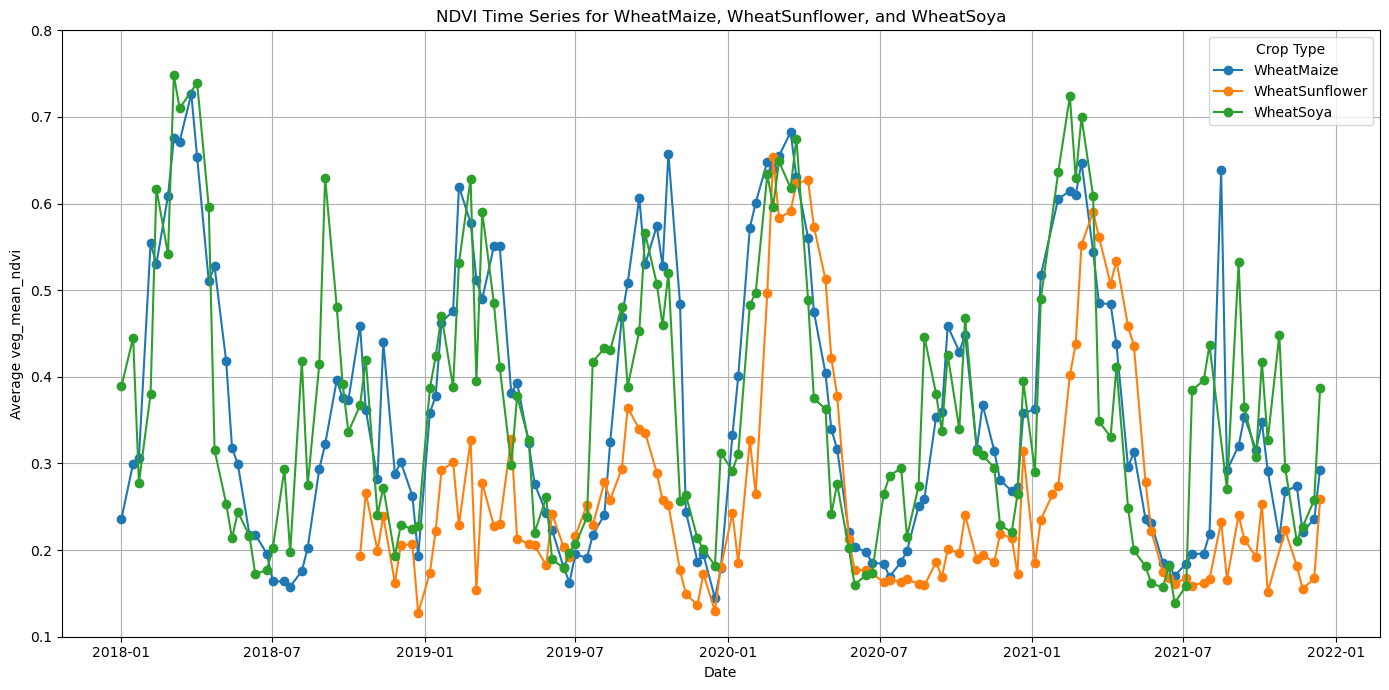

In [ ]:
# Ensure numeric
df2["week"] = pd.to_numeric(df2["week"], errors="coerce")
df2["veg_mean_ndvi"] = pd.to_numeric(df2["veg_mean_ndvi"], errors="coerce")
df2["Year"] = pd.to_numeric(df2["Year"], errors="coerce")

# Drop rows with invalid weeks or years
df2 = df2.dropna(subset=["Year", "week"])
df2 = df2[df2["week"] > 0]  # ISO weeks start from 1

# Filter only for WheatMaize, WheatSunflower, WheatSoya
selected_crops = ["WheatMaize", "WheatSunflower", "WheatSoya"]
df_crop = df2[df2["Crop_type"].isin(selected_crops)].copy()

# Create datetime from Year, Week, and weekday=1 (Monday)
def iso_to_date(year, week):
    try:
        return datetime.fromisocalendar(int(year), int(week), 1)
    except:
        return pd.NaT

df_crop["date"] = df_crop.apply(lambda row: iso_to_date(row["Year"], row["week"]), axis=1)
df_crop = df_crop.dropna(subset=["date"])

# Group by crop type and date
avg_ndvi = df_crop.groupby(["Crop_type", "date"], as_index=False)["veg_mean_ndvi"].mean()

# Plotting
plt.figure(figsize=(14, 7))

for crop in selected_crops:
    subset = avg_ndvi[avg_ndvi["Crop_type"] == crop].sort_values("date")
    plt.plot(
        subset["date"].to_numpy(),
        subset["veg_mean_ndvi"].to_numpy(),
        marker="o",
        linestyle="-",
        label=crop
    )

plt.xlabel("Date")
plt.ylabel("Average veg_mean_ndvi")
plt.title("NDVI Time Series for WheatMaize, WheatSunflower, and WheatSoya")
plt.legend(title="Crop Type")
plt.grid(True)
plt.tight_layout()
plt.ylim(0.1, 0.8)
plt.show()
